# Imports

In [40]:
"""------------SECTION IMPORTS---------------------"""
import numpy as np
import pandas as pd
import joblib
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings("ignore")
# Define search space for number of trees in random forest and depth of trees
num_trees_min = 64
num_trees_max = 128

depth_min = 2
depth_max = 7

# Load data

In [41]:
df = pd.read_csv("data/no_missings_sy.csv")
df = df.drop("Unnamed: 0",axis=1)
df.head()

,date,district,prevalence,next_prevalence,prevalence_6lag,ndvi,ipc,population,month,district_encoded,increase
0,2018-01-01,Burco,0.20280,0.22114,0.33594,0.18500,0.05000,534884.89500,1,21,True
1,2018-01-01,Xudur,0.48620,0.46890,0.48620,0.24833,0.14000,113853.10500,1,77,False
2,2018-01-01,Bossaso,0.34320,0.48221,0.41606,0.14833,0.01000,316531.98000,1,18,True
3,2018-01-01,Cadale,0.35100,0.28292,0.36920,0.22667,0.00000,48461.80500,1,27,False
4,2018-01-01,Qoryooley,0.35100,0.43638,0.36920,0.34667,0.09000,196309.48500,1,65,True


In [42]:
'''------------SECTION RANDOM FOREST CROSS VALIDATION--------------'''
# WARNING: this process can take some time, since there are a lot of hyperparameters to investigate. The search space can be manually reduced to speed up the process.

# Create empty list to store model scores
parameter_scores = []

# Define target and explanatory variables
X = df.select_dtypes(exclude=["category","object"]).drop(["increase", "prevalence", "next_prevalence"],axis=1)
y = df['next_prevalence'].values

# Explore differences in districts in baseline vs preprocessed data

In [43]:
baseline_data = pd.read_csv("data/baseline_data.csv")

# Get districts
baseline_districts  = np.sort(baseline_data.district.unique())
preprocessed_districts = np.sort(df.district.unique())

# Compare districts
presence  = []
for d in preprocessed_districts:
    if d not in baseline_districts:
        presence.append(1)
    else:
        presence.append(0)

In [44]:
new_districts = pd.DataFrame({"pre_districts":preprocessed_districts, "not_present_in_baseline":presence})
#new_districts.to_csv("new_districts.csv")

In [45]:
new_districts

,pre_districts,not_present_in_baseline
0,Adan Yabaal,1
1,Afgooye,0
2,Afmadow,1
3,Baardheere,0
4,Badhaadhe,0
...,...,...
64,Wanla Weyn,1
65,Xarardheere,0
66,Xudun,1
67,Xudur,0


# Load model

In [46]:
loaded_model_sy = joblib.load("baseline_semiyearly_model.joblib")

In [47]:
loaded_model_sy

RandomForestRegressor(max_depth=2, max_features='auto', n_estimators=122,
                      n_jobs=-1, random_state=0)

# Evaluate model

In [48]:
train_split = 345

In [49]:
# Perform evaluation on full data
Xtrain = X[:train_split]
ytrain = y[:train_split]
Xtest = X[train_split:]
ytest = y[train_split:]

In [50]:
loaded_model_sy.fit(Xtrain, ytrain)
predictions = loaded_model_sy.predict(Xtest)

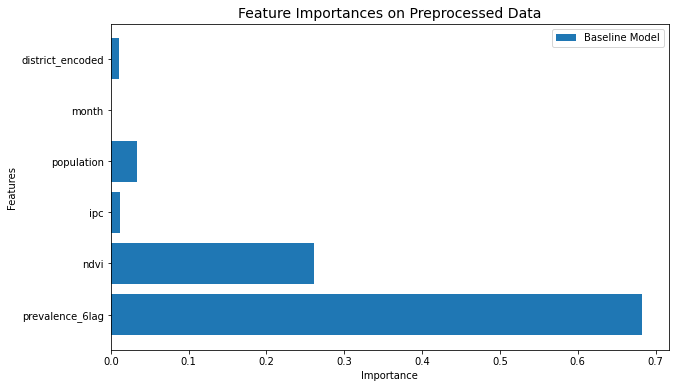

In [51]:
# Feature Importance
plt.figure(figsize=(10,6))
plt.title("Feature Importances on Preprocessed Data", size=14)
plt.barh(X.columns, loaded_model_sy.feature_importances_)
plt.xlabel("Importance")
plt.ylabel("Features")
plt.legend(["Baseline Model"]);

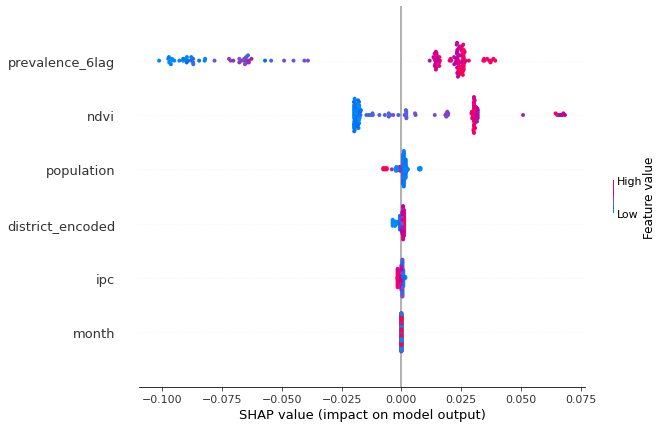

In [52]:
import shap
explainer = shap.TreeExplainer(loaded_model_sy)
shap_values = explainer.shap_values(Xtest)
shap.summary_plot(shap_values, Xtest, plot_size=(10,7))

# Visualise predictions
Each data point on the graph is a single district so these graphs are not informative

In [53]:
len(ytest), len(predictions)

(138, 138)

In [54]:
from helper_metrics import plot_time_series

In [55]:
from datetime import datetime
timesteps = [datetime.strptime(i, "%Y-%m-%d") for i in df.date]

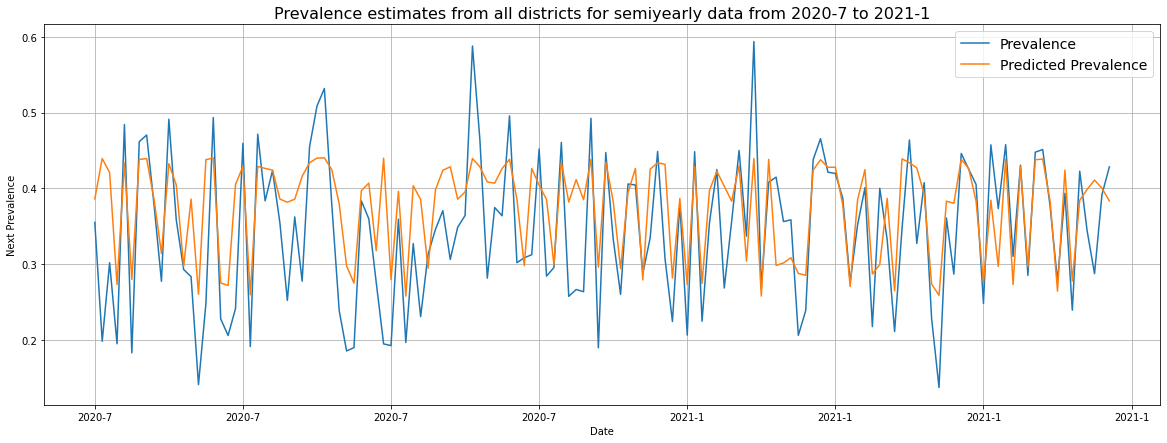

In [56]:
plt.figure(figsize=(20,7))
plt.title("Prevalence estimates from all districts for semiyearly data from 2020-7 to 2021-1",size=16)
plot_time_series(timesteps=np.arange(138),values=ytest, label="Prevalence")
plot_time_series(timesteps=np.arange(138),values=predictions, label="Predicted Prevalence")
plt.xticks(np.arange(0,160,step=20),labels=["2020-7", "2020-7", "2020-7", "2020-7", "2021-1","2021-1", "2021-1","2021-1"]);

# Naive Forecast

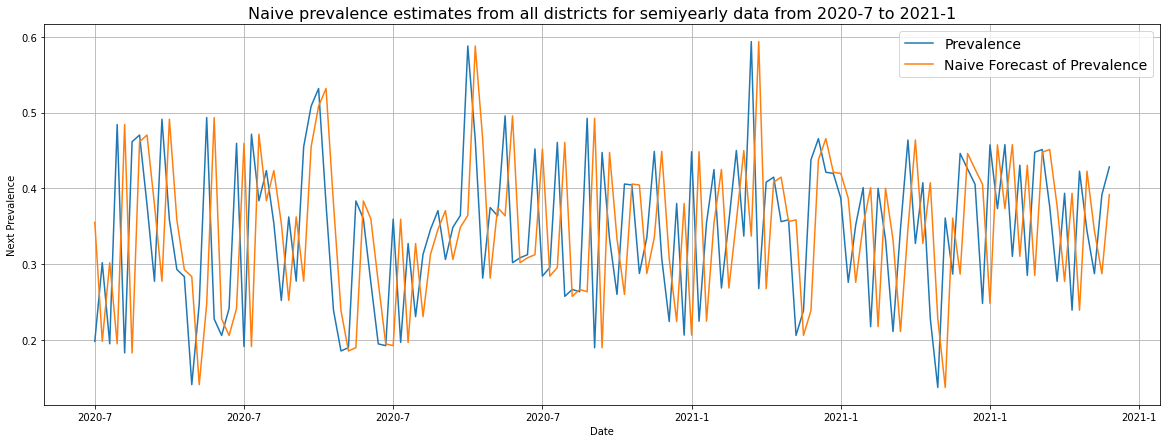

In [57]:
naive_forecast = ytest[:-1]
plt.figure(figsize=(20,7))
plt.title("Naive prevalence estimates from all districts for semiyearly data from 2020-7 to 2021-1",size=16)
plot_time_series(timesteps=np.arange(137),values=ytest[1:], label="Prevalence")
plot_time_series(timesteps=np.arange(137),values=naive_forecast, label="Naive Forecast of Prevalence")
plt.xticks(np.arange(0,160,step=20),labels=["2020-7", "2020-7", "2020-7", "2020-7", "2021-1","2021-1", "2021-1","2021-1"]);

In [58]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [59]:
# MAE
baseline_prep_mae = mean_absolute_error(y_true=ytest, y_pred=predictions)
naive_mae = mean_absolute_error(y_true=ytest[1:], y_pred=naive_forecast)

In [60]:
# MSE
baseline_prep_mse = mean_squared_error(y_true=ytest, y_pred=predictions)
naive_mse = mean_squared_error(y_true=ytest[1:], y_pred=naive_forecast)

In [61]:
# RMSE
baseline_prep_rmse = np.sqrt(mean_squared_error(y_true=ytest, y_pred=predictions))
naive_rmse = np.sqrt(mean_squared_error(y_true=ytest[1:], y_pred=naive_forecast))

In [62]:
results_df = pd.DataFrame({"Model":["Baseline Preprocessed", "Naive Forecast"], "MAE":[baseline_prep_mae, naive_mae],
              "MSE":[baseline_prep_mse, naive_mse], "RMSE":[baseline_prep_rmse, naive_rmse]})
results_df

,Model,MAE,MSE,RMSE
0,Baseline Preprocessed,0.05851,0.00578,0.07602
1,Naive Forecast,0.11544,0.01946,0.13950


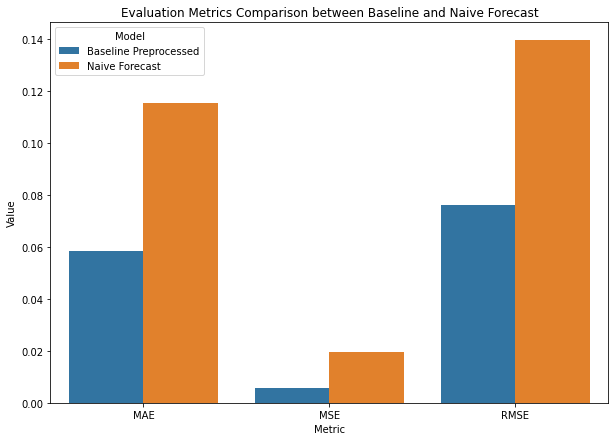

In [63]:
results_df = pd.DataFrame({"Model":["Baseline Preprocessed", "Naive Forecast", "Baseline Preprocessed", "Naive Forecast", "Baseline Preprocessed", "Naive Forecast"], "Metric":["MAE", "MAE", "MSE", "MSE", "RMSE", "RMSE"],
              "Value":[baseline_prep_mae, naive_mae, baseline_prep_mse, naive_mse, baseline_prep_rmse, naive_rmse]})

plt.figure(figsize=(10,7))
plt.title("Evaluation Metrics Comparison between Baseline and Naive Forecast")
sns.barplot(results_df, x="Metric", y="Value", hue="Model");